# **Project 6**
# **Team 3 :- Megha , Sagar**
In this assignment you will work in groups of 2 or 3 as done in the previous assignment, to gain experience in applying various clustering algorithms to a variety of datasets and comparing the results. You will find benchmark image datasets here: https://www.tensorflow.org/datasets/catalog/overview (Links to an external site.)

1) Select 4 types of image data

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

5) Train a Gaussian mixture model on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.


In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import urllib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import IPython.display as display
from PIL import Image

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

 Selected 2 types of image data: 
 *   MNIST
 *   Fashion-MNIST

#load MNIST dataset

We have selcted MNIST as one of the datset.

*   To know the clustering algorithm on image dataset.




I clustering algorithm, unsupervised Algorithm does not have labels to predict the scores. Only we need is features. So We can import data as before. Later we will not use y_train which is label.

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)


In [0]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

#Split dataset

Dividing the dataset into the training set, test set and validation set.
We are dividing dataset into 70% for training, 15% for testing and rest for validation set.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=10500, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(mnist.data, mnist.target))
X_train_valid = mnist.data[train_valid_idx]
y_train_valid = mnist.target[train_valid_idx]
X_test = mnist.data[test_idx]
y_test = mnist.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=15000, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]


Print out the shape of each set to know number of instances and dimensions

In [0]:
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)
print("Validation set:", X_valid.shape, y_valid.shape)


Training set: (44500, 784) (44500,)
Testing set: (10500, 784) (10500,)
Validation set: (15000, 784) (15000,)


#Kmeans Clustering

Used the mini-batch implementation of k-means clustering provided by scikit-learn. This will reduce the amount of time it takes to fit the algorithm to the data due to the large number of dataset. 
The MNIST dataset contains images of the integers 0 to 9. Because of this, let's start by setting the number of clusters to 10, one for each digit.

In [0]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [0]:
kmeans.labels_

array([3, 9, 6, ..., 3, 5, 7], dtype=int32)

K-means clustering is an unsupervised machine learning method; consequently, the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer. To fix this, let's define a few functions that will predict which integer corresponds to each cluster.

In [0]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
              # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print (predicted_labels[:20])
print (Y[:20])

[3 0 4 1 7 2 1 3 1 7 3 8 3 6 1 7 2 8 1 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


With the functions defined above, we can now determine the accuracy of our algorithms. Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are inertia and homogeneity.

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.

In [0]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [0]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2386843.2746164426
Homogeneity: 0.4525276782410099
Accuracy: 0.5303666666666667

Number of Clusters: 16
Inertia: 2209870.5160428113
Homogeneity: 0.562136234569839
Accuracy: 0.6575833333333333

Number of Clusters: 36
Inertia: 1953658.1625964418
Homogeneity: 0.6879951519738412
Accuracy: 0.7778

Number of Clusters: 64
Inertia: 1983219.609360702
Homogeneity: 0.6835500149109663
Accuracy: 0.7560166666666667

Number of Clusters: 144
Inertia: 1637802.6142291431
Homogeneity: 0.7954623772364795
Accuracy: 0.84785

Number of Clusters: 256
Inertia: 1519270.8967068691
Homogeneity: 0.8387013557086431
Accuracy: 0.8869833333333333



#Visualize cluster centroids

The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784. We can reshape this array back into a 28 by 28 pixel image and plot it.

These graphs will display the most representative image for each cluster.

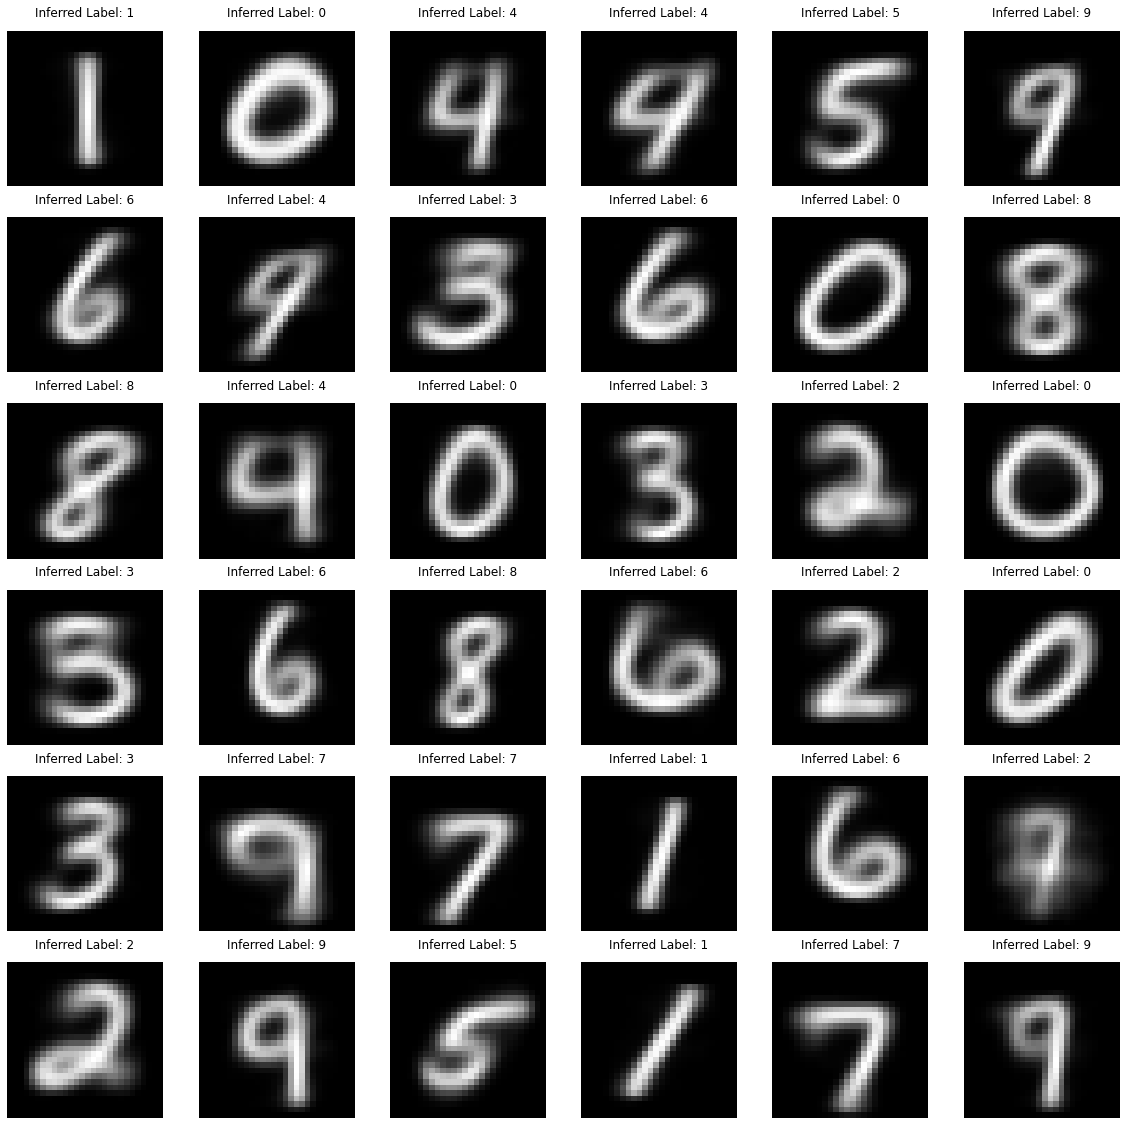

In [0]:
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

#Kmeans on reduced dimensionality

In [0]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

331

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

In [0]:
from sklearn.cluster import KMeans

k_range = range(1,11)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10


#Plotting Elbow

In [0]:
from sklearn.cluster import KMeans

k=10
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [0]:
inertias

[3163502.1297076102,
 2960780.802520703,
 2816456.487184891,
 2707243.4836170147,
 2605960.4275039136,
 2533295.8754246235,
 2479887.870150585,
 2432393.903898479,
 2388861.6954543474,
 2352826.3658958077]

Text(0, 0.5, 'inertia')

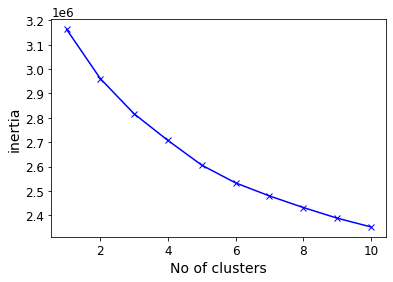

In [0]:
from sklearn.cluster import KMeans
K = range(1, 11)
meandistortions = []
inertia= []
for k in K:
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=0)
    kmeans.fit(d2_X_train_mnist)

    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('No of clusters')
plt.ylabel('inertia')

In [0]:
kmeans.inertia_


123324823987.86226

# best k using silhouette and draw the Elbow

In [0]:
from sklearn.metrics import silhouette_score

In [0]:
silhouette_score(X_train_pca, kmeans.labels_)

0.057506548706733135

In [0]:
silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

In [0]:
best_index = np.argmax(silhouette_scores)

In [0]:
best_k = k_range[best_index]

In [0]:
best_score = silhouette_scores[best_index]

In [0]:
best_score

0.07002580371425955

In [0]:
k_range

range(1, 11)

In [0]:
best_k

10

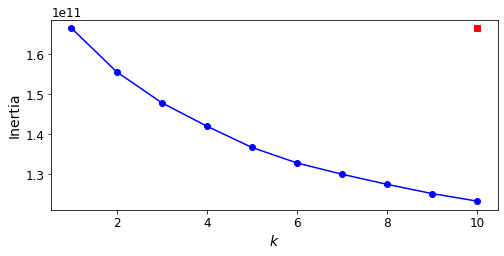

In [0]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

the best k= 10.

In [0]:
best_model = kmeans_per_k[best_index]

#Train a classifier

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

In [0]:
from sklearn.ensemble import RandomForestClassifier
Random_clf = RandomForestClassifier(n_estimators=150, random_state=42)
Random_clf.fit(X_train, y_train)
Random_clf.score(X_test, y_test)

0.9635238095238096

Here we train a classifier to predict number in the image.

In [0]:
from sklearn.ensemble import RandomForestClassifier

Random_clf = RandomForestClassifier(n_estimators=150, random_state=42)
Random_clf.fit(X_train_pca, y_train)
Random_clf.score(X_valid_pca, y_valid)

0.9374

So without using PCA dimensional reduction, We got the 96. This is Not bad Score. When we used Random forest on reduced dimensions we got 94. But we can see how it will effect if we use Kmeans as dimension reduction.

#K-Means as a dimensionality reduction tool

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

In [0]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

Random_clf = RandomForestClassifier(n_estimators=150, random_state=42)
Random_clf.fit(X_train_reduced, y_train)
    
Random_clf.score(X_valid_reduced, y_valid)

0.1502

We got very bad score after used K-means as a dimensionality reduction tool for Random forest classifier.

Search for the number of clusters that provides the best performance.
* there are two ways to search for clusters
1} using Grid  search when we dont have validation set. But we want to know how this works for this dataset.


In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(15, 100, 10))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(d2_X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] kmeans__n_clusters=15 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=15, total= 1.5min
[CV] kmeans__n_clusters=15 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] ............................ kmeans__n_clusters=15, total= 1.5min
[CV] kmeans__n_clusters=15 ...........................................
[CV] ............................ kmeans__n_clusters=15, total= 1.3min
[CV] kmeans__n_clusters=25 ...........................................
[CV] ............................ kmeans__n_clusters=25, total= 2.0min
[CV] kmeans__n_clusters=25 ...........................................
[CV] ............................ kmeans__n_clusters=25, total= 2.0min
[CV] kmeans__n_clusters=25 ...........................................
[CV] ............................ kmeans__n_clusters=25, total= 2.1min
[CV] kmeans__n_clusters=35 ...........................................
[CV] ............................ kmeans__n_clusters=35, total= 2.4min
[CV] kmeans__n_clusters=35 ...........................................
[CV] ............................ kmeans__n_clusters=35, total= 2.5min
[CV] kmeans__n_clusters=35 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 93.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=15, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('rnd_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gin

In [0]:
grid_clf.score(X_test, y_test)

In [0]:
grid_clf.best_params_

Another way to search the number of clusters when we dont need K - folds

In [0]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("Random_forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

1 0.1502
2 0.30606666666666665
3 0.46413333333333334
4 0.5872666666666667
5 0.7257333333333333
6 0.7671333333333333
7 0.7941333333333334
8 0.8383333333333334
9 0.8539333333333333
10 0.8754


By using the number of clusters, we got beyond 85% accuracy. Looks like the distances to the cluster centroids are very informative as the original images.

In [0]:
X_train_tocheck = np.c_[X_train_pca, X_train_reduced]
X_valid_tocheck = np.c_[X_valid_pca, X_valid_reduced]
X_test_tocheck= np.c_[X_test_pca, X_test_reduced]

In [0]:
Random_clf = RandomForestClassifier(n_estimators=150, random_state=42)
Random_clf.fit(X_train_tocheck, y_train)
Random_clf.score(X_valid_tocheck, y_valid)

0.9384666666666667

It is good score than using number of clusters. 

#Gaussian mixture

5) Train a Gaussian mixture model  on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

In [0]:
To speed things up, we'll reduce the data's dimensionality using PCA:

In [0]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

In [0]:
y_pred

array([11, 27,  8, ...,  5,  1, 18])

In [0]:
gm.means_

array([[-1.18723585e+02,  5.40798579e+02,  5.00974405e+02, ...,
        -1.18361893e+00,  6.70746127e-01, -2.73163220e-01],
       [-8.37521528e+02, -6.25146523e+02,  2.35711069e+02, ...,
         9.63623641e-01, -4.31942261e-01,  7.92597417e-01],
       [ 1.21327411e+03, -2.75705496e+02,  1.96978873e+02, ...,
         1.74536828e-01,  6.77705763e-01,  1.07355224e+00],
       ...,
       [ 4.08772921e+02, -1.64784397e+02,  6.90474869e+02, ...,
        -2.26409257e+00,  1.14347748e+00,  2.03336614e-01],
       [ 4.57194002e+02, -4.17539676e+02, -7.78053905e+02, ...,
        -1.97238322e-01,  6.64505062e-01,  7.58848983e-01],
       [ 1.03816012e+03, -2.93474614e+02, -4.09049156e+02, ...,
         7.59621808e-01,  3.89461234e-01, -7.46939870e-01]])

In [0]:
gm.weights_

In [0]:
gm.covariances_

array([[[ 7.58169439e+04,  5.08021072e+04,  2.58121635e+04, ...,
         -1.08605966e+02, -5.97175269e+01,  2.50242503e+02],
        [ 5.08021072e+04,  7.60068975e+04,  8.18634095e+03, ...,
         -1.64811959e+02, -4.45390860e+01,  1.46329127e+02],
        [ 2.58121635e+04,  8.18634095e+03,  4.83580090e+04, ...,
         -1.14642012e+02, -2.36014848e+02, -2.56564934e+02],
        ...,
        [-1.08605966e+02, -1.64811959e+02, -1.14642012e+02, ...,
          3.40036007e+02,  2.93497058e+01, -1.68273401e+01],
        [-5.97175269e+01, -4.45390860e+01, -2.36014848e+02, ...,
          2.93497058e+01,  4.20030726e+02, -6.11682214e+00],
        [ 2.50242503e+02,  1.46329127e+02, -2.56564934e+02, ...,
         -1.68273401e+01, -6.11682214e+00,  4.00521351e+02]],

       [[ 8.04538858e+03, -1.13022566e+02,  8.26340984e+02, ...,
         -1.94183413e+01, -3.90647651e+01,  4.99500335e+00],
        [-1.13022566e+02,  2.43146917e+04, -9.61976805e+03, ...,
         -1.98253635e+02, -6.53025457e

In [0]:
gm.converged_

True

# **Fashion Mnist Data set**

# **Import the data set here:-**

In [0]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
print(f"Length of  X_train: {X_train.shape}, Length of y_train is: {y_train.shape}")
print(f"Length of  X_test:{X_test.shape}, Length of y_test is{y_test.shape}")

4423680/4422102 [==============================] - 0s 0us/step
Length of  X_train: (60000, 28, 28), Length of y_train is: (60000,)
Length of  X_test:(10000, 28, 28), Length of y_test is(10000,)


Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Load the data set:-

tf.keras.datasets.fashion_mnist.load_data() returns 2 tuples here:

x_train, x_test: Numpy array of image data(number_samples, 28, 28).

y_train, y_test: Numpy array of category labels here (integers in range 0-9): (num_samples, )..

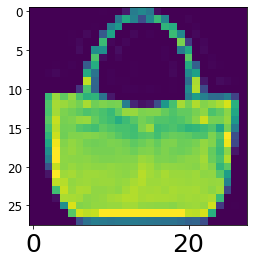

In [0]:
#playing
plt.figure(10)
img = plt.imshow(X_train[100])

In [0]:
#Convert the X_train and X_test data into 2d array here:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny))

# **K-Means**
# **2) For Fashion Mnist  dataset, cluster the images using K-Means and plot the elbow graph to show the best K.**

# **Measure the cluster Quality**


Inertia: To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance . This is the idea behind the inertia metric. Inertia is the sum of the squared distances between each training instance and its closest centroid: Intuitively, inertia tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for. The range of inertia’s value starts from zero and goes up.

In [0]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(d2_X_train)
                for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [0]:
inertias

[266145742269.8958,
 210227913258.5017,
 179902121080.95123,
 162902317417.76633,
 152978184720.74774,
 143226836111.02786,
 136511763616.59668,
 131850619826.63737,
 127657799088.01968,
 123980093641.66411,
 120825767822.00015,
 117713019517.20345,
 115109756672.49347,
 112951416116.64557]

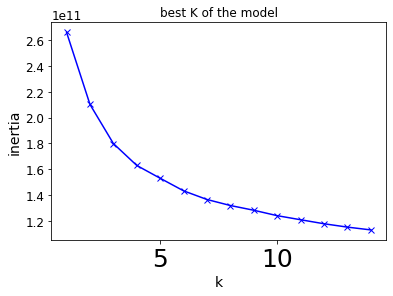

In [0]:
from sklearn.cluster import KMeans
K = range(1, 15)
meandistortions = []
inertia= []
for k in K:
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=0)
    kmeans.fit(d2_X_train)

    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('best K of the model');


Elbow method says that you can find K where there is an elbow here before elbow error gradually decreases and after elbow the decrease isn’t significant, as you can see in the graph here, inertias goes down significantly as the K goes bigger. But it's hard to tell how much bigger the K needs to go. As the K-means show in the above graph, the inertia is pretty much close to the X- .

In [0]:
#here we assumed K=15 first here
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(d2_X_train)
y_pred

array([ 8, 12,  1, ...,  3,  1, 10], dtype=int32)

In [0]:
y_pred is kmeans.labels_

True

We following 15 centroids cluster center estimated here:-

In [0]:
kmeans.cluster_centers_

array([[ 3.57786717e-17,  2.56718813e-02,  8.26313678e-02, ...,
         8.92980345e+00,  3.85960690e+00,  5.03008424e-01],
       [ 2.16483686e-03,  4.94819855e-03,  3.15447657e-02, ...,
         8.42121540e-01,  2.48183083e-01,  1.93289006e-02],
       [ 3.79794911e-04,  6.83630839e-03,  2.73452336e-02, ...,
         8.60805165e+00,  3.57424991e+00,  1.68249145e-01],
       ...,
       [ 2.58732212e-03,  1.91461837e-02,  1.49029754e-01, ...,
         7.01164295e-02,  1.39715395e-02,  3.10478655e-03],
       [ 5.18248638e-17,  2.78164117e-04, -7.32053307e-16, ...,
         2.53129346e-02,  3.89429764e-03,  3.89429764e-03],
       [ 1.33049494e-03,  1.49015434e-02,  9.26024481e-02, ...,
         1.48863757e+01,  2.29563598e+00,  1.57264502e-01]])

In [0]:
kmeans.inertia_

111250075327.65587

In [0]:
X_dist = kmeans.transform(d2_X_train)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

111250075327.65582

**Inertia is the sum of squares for all dataset points to their closest centroid**

###**Silhouette Score**
Silhouette score tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1. Score should be closer to 1 than -1.

Let's plot the silhouette score as a function of k :-

In [0]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(d2_X_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [0]:
silhouette_scores

[0.19292353740440155,
 0.1868631541189012,
 0.18034836892941103,
 0.16157394858536603,
 0.15622240618672606,
 0.16538973599142445,
 0.15433385392127688,
 0.15707003166825867,
 0.15490771631045844,
 0.14176947734258036,
 0.1378153276793143,
 0.13151804043796553,
 0.1303538193753024]

**informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram here**

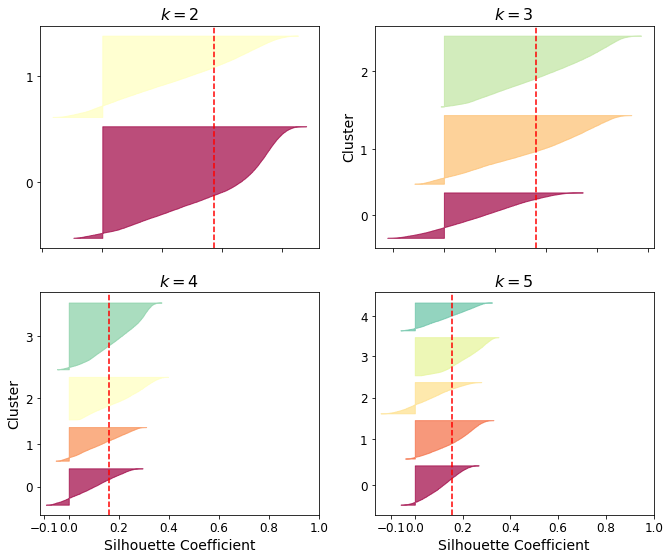

In [0]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(d2_X_train, y_pred)

    padding = len(d2_X_train) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Here is the chart shows that K=2 which is the highest values of silhoute score and the best k is 2 

# **Train a Classifier**

**3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.**

### **Random Forest Classifier**


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(d2_X_train, y_train)
clf.score(d2_X_test, y_test)

0.8781

here is Without the dimensionality reduction accuracy is 87.81

# Using K-mean Clustering as Dimension Reduction for Classification

**4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.**

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=15, random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=150, random_state=42)),
])
pipeline.fit(d2_X_train, y_train)
pipeline.score(d2_X_test, y_test)

0.7839

here with the cluster = 15, the accuracy actually decreased instead of improving, since this cluster number is arbitary . Here let's we try to find the best k, when the accuracy score increased .and it takes almost half day for this.

In [0]:
grid_clf.best_params_

{'kmeans__n_clusters': 95}

In [0]:
grid_clf.score(d2_X_test, y_test)

0.8138

after the 27 runs ,from 10-100, the best value is 95, the accuracy still lower than the orginial set (reduced from 87.81% to 81.38%. Now we are testing using K-mean (k=95) as a dimension reduction tool.

In [0]:
best_model = KMeans(n_clusters=95, random_state=42).fit(d2_X_train)
X_train_reduced = best_model.transform(d2_X_train)
X_test_reduced = best_model.transform(d2_X_test)

In [0]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_test_reduced, y_test)

0.8112

# Gaussian Mixture Model Test
**5) Train a Gaussian mixture model on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).**




let's we use the t-SNE to reduce dimensionality down to 2 dimension so we can plot the dataset. Current dimension is 784. And use PCA to speeddup the t-SNE. now as a  previous projects and study, we know that the best dimension reduction technique to work with t-SNE is PCA. let's do this. 

In [0]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [0]:
from sklearn.manifold import TSNE 
from sklearn.pipeline import Pipeline
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.99, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(d2_X_train)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))

PCA+t-SNE took 1919.0s.


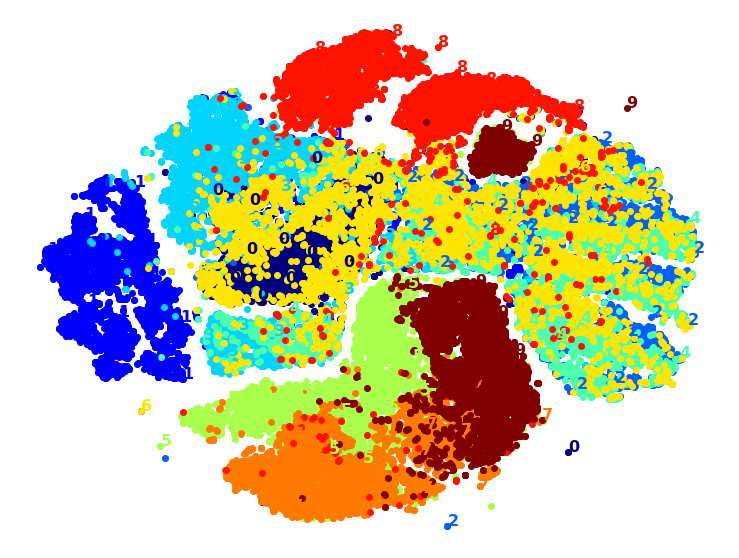

In [0]:
plot_digits(X_pca_tsne_reduced, y_train)
plt.show()

####**Train Gaussian Mixture Model.**
 1. use the PCA & t-SNE reduced data 

In [0]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_pca_tsne_reduced)
gm.means_

array([[ 31.75862494,  15.81733366],
       [-42.17635255,   1.05846369],
       [ -4.27526772, -39.37809547],
       [ 17.91453679, -21.02909121],
       [ -4.56829834,  18.06787714],
       [-38.09813338, -14.5488513 ],
       [-10.83842367,  44.00511602],
       [ 43.1727019 , -19.18143192],
       [-30.82792231,  32.43274247],
       [ 10.28102702,  38.52504929],
       [-11.27178402,   2.3921657 ],
       [ 21.63363361, -31.46548308],
       [ 46.83173212,  11.82230117],
       [-17.10278254, -47.96510235],
       [  7.47607823,   7.60841867],
       [ 20.29849367,  11.32052242],
       [  0.26042886,  -9.32809149],
       [ 12.0987852 , -38.36344761],
       [ 22.14225224,  42.63867654],
       [-19.04834367,  16.73593901],
       [-12.93897323, -33.41295747],
       [-52.16908411,   3.92408426],
       [  2.58758427, -23.77344219],
       [ 21.40097649,  29.26816177],
       [  9.50915057,  19.65967578],
       [-48.97724996, -14.21792724],
       [-26.07060676, -15.7789976 ],
 

In [0]:
gm.weights_

array([0.02563781, 0.01429786, 0.02173165, 0.0254394 , 0.03136597,
       0.01571453, 0.03213259, 0.03282797, 0.03092815, 0.02738807,
       0.03578401, 0.02341818, 0.02821133, 0.02985574, 0.02166419,
       0.0322457 , 0.02197547, 0.02550795, 0.02008737, 0.02596266,
       0.02650886, 0.02792922, 0.02842026, 0.01603377, 0.02353761,
       0.02263096, 0.01850913, 0.025142  , 0.0306688 , 0.02792134,
       0.02362033, 0.020777  , 0.02458294, 0.01624383, 0.02262998,
       0.01883136, 0.01259152, 0.03289951, 0.03549452, 0.02285047])

In [0]:
gm.covariances_

array([[[ 27.10675848,  -8.45486613],
        [ -8.45486613,  30.80468568]],

       [[  7.32589813,  -8.41062085],
        [ -8.41062085,  33.87521107]],

       [[ 21.68664303,   5.99553577],
        [  5.99553577,  24.3387885 ]],

       [[ 18.30344566,   4.82286364],
        [  4.82286364,  25.44696661]],

       [[ 16.93969325,   9.18564581],
        [  9.18564581,  29.97797832]],

       [[  4.90830876,  -4.23208738],
        [ -4.23208738,  35.41837679]],

       [[ 19.37124708,   2.18201572],
        [  2.18201572,  21.96117286]],

       [[ 32.86643575,   9.53445823],
        [  9.53445823,  25.49103339]],

       [[ 18.47305223,   7.63505733],
        [  7.63505733,  33.3671019 ]],

       [[ 13.84010359,   0.25898568],
        [  0.25898568,  18.39547133]],

       [[ 21.71696415,   4.21890264],
        [  4.21890264,  42.17695396]],

       [[ 11.06478091,   5.03958752],
        [  5.03958752,  28.05440858]],

       [[ 24.77483346,  -8.98670384],
        [ -8.98670384,  25

In [0]:
gm.converged_

True

In [0]:
gm.n_iter_

9

**6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.**

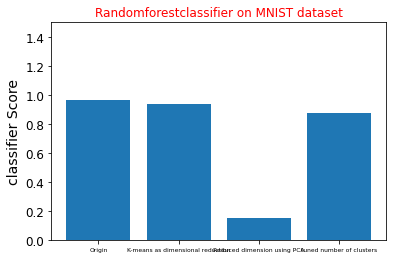

In [0]:
names = ['Origin', 'K-means as dimensional reduction', 'Reduced dimension using PCA', 'tuned number of clusters']
values = [0.9635, 0.9374, 0.1502, 0.8754 ]
plt.bar(names, values)
plt.rc('xtick', labelsize=7)
plt.ylim(0,1.5)
plt.ylabel("classifier Score")
plt.title("Randomforestclassifier on MNIST dataset", color = "red", fontsize = "large")
plt.show()

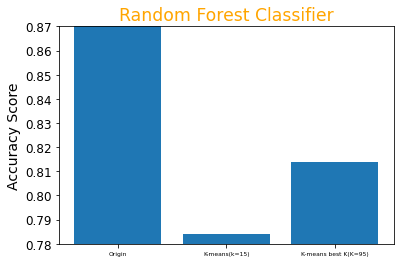

In [0]:
names = ['Origin', 'K-means(k=15)', 'K-means best K(K=95)']
values = [0.8781, 0.7839, 0.8138]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0.78,0.87)
plt.ylabel("Accuracy Score")
plt.title("Kmeans", color = "orange", fontsize = "xx-large")
plt.show()

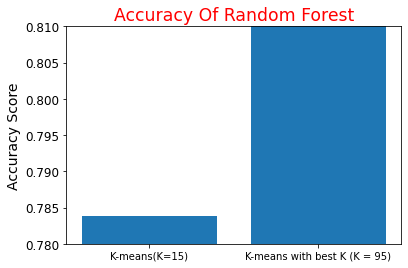

In [0]:
names = ['K-means(K=15)', 'K-means with best K (K = 95)']
values = [0.7839, 0.8138]
plt.bar(names, values)
plt.rc('xtick', labelsize = 25)
plt.ylim(0.78,0.81)
plt.ylabel("Accuracy Score")
plt.title("Accuracy Of Random Forest", color = "red", fontsize = "xx-large")
plt.show()

#Report

**For MNIST dataset**
Without using PCA dimensional reduction, We got the 96. This is Not bad Score. When we used Random forest on reduced dimensions we got score of 94. But we can see how it will effect if we use Kmeans as dimension reduction.

When We used K-means as dimensional reduction tool on MNIST dataset.
We got very bad score 15 after used K-means as a dimensionality reduction tool for Random forest classifier.

When used number of clusters:
By using the number of clusters, we got beyond 85% accuracy. Looks like the distances to the cluster centroids are bit useful.

So it is better to use Random forest without applying the dimensional reduction(PCA). Or With Using PCA with Variance 99% will yeild good score for randomforest classifier on MNIST dataset.

The clusters are not that useful to directly train a classifier in this dataset.

**Fashion Mnist***
In this Dataset we use Fashion MNIST dataset with Random Forest Classifier.and the accuracy is 87.81 without dimensionality reduction after that implement the k-means algorithm dimensional reduction techniques and With the cluster = 15, after this method accuracy is (K=15):- 0.7839 .and the cluster number is arbitary here, after the 27 runs ,from 10-100, the best value is 95, the accuracy still lower than the orginial set (reduced from 87.81% to 81.38%. Now we are testing using K-mean (k=95) as a dimension reduction tool.. . The accuracy not increased it's still 81.38 .we use the t-SNE to reduce dimensionality down to 2 dimension so we can plot the dataset. t-sne which is best dimensionality reduction method and then applied test and train gaussian model and show the accuraccy in graph.

# **References:**

[https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a](https://)

[https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a](https://)

[https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb](https://)

